In [2]:
import os

import joblib
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

print(os.listdir("../data"))
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

['IMDB Dataset.csv']


In [3]:

models_path = "../models/"
X_train, X_test, y_train, y_test = joblib.load(models_path + "split_data.pkl")

In [4]:
# Tokenization
tokenizer = Tokenizer(
    num_words=30000,
    oov_token="<OOV>",  # Out-of-Vocabulary
)

tokenizer.fit_on_texts(X_train)

In [5]:
# Text → sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [6]:
# Padding
MAX_LEN = 200

X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

In [7]:
print(X_train_pad.shape)
print(X_test_pad.shape)
print(y_train.shape, y_test.shape)

(40000, 200)
(10000, 200)
(40000,) (10000,)


In [8]:
y_train.head()

47808    positive
20154    negative
43069    negative
19413    negative
13673    negative
Name: sentiment, dtype: str

In [9]:
y_train_num = y_train.map({'positive': 1, 'negative': 0})
y_test_num = y_test.map({'positive': 1, 'negative': 0})

In [10]:
# Validation set
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_pad,
    y_train_num,
    test_size=0.1,
    random_state=42,
    stratify=y_train_num
)

In [11]:
model = Sequential([
    Embedding(
        input_dim=30000,
        output_dim=128,
        input_length=MAX_LEN
    ),
    Dropout(0.3),
    GlobalAveragePooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [12]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Show progress bar
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.epochs, desc='Training Progress')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(val_loss=logs.get('val_loss'), val_acc=logs.get('val_accuracy'))

    def on_train_end(self, logs=None):
        self.pbar.close()

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,  # Wait 2 epochs if the loss doesn't decrease, stop.
    restore_best_weights=True  # # Retain the weight of the best epoch
)

In [16]:
base_model = model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=20,
    batch_size=128,
    callbacks=[early_stop, TQDMProgressBar()])


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6535 - loss: 0.6182

Training Progress:   5%|▌         | 1/20 [00:03<01:10,  3.69s/it, val_acc=0.8, val_loss=0.423]

282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7474 - loss: 0.5139 - val_accuracy: 0.8005 - val_loss: 0.4227
Epoch 2/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8785 - loss: 0.3043

Training Progress:  10%|█         | 2/20 [00:06<00:58,  3.25s/it, val_acc=0.859, val_loss=0.312]

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8812 - loss: 0.2927 - val_accuracy: 0.8595 - val_loss: 0.3117
Epoch 3/20
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9148 - loss: 0.2281

Training Progress:  15%|█▌        | 3/20 [00:09<00:51,  3.06s/it, val_acc=0.86, val_loss=0.32]  

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9143 - loss: 0.2279 - val_accuracy: 0.8600 - val_loss: 0.3203
Epoch 4/20
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9327 - loss: 0.1907

Training Progress:  20%|██        | 4/20 [00:12<00:47,  2.98s/it, val_acc=0.882, val_loss=0.295]

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9314 - loss: 0.1901 - val_accuracy: 0.8817 - val_loss: 0.2955
Epoch 5/20
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9471 - loss: 0.1590

Training Progress:  25%|██▌       | 5/20 [00:15<00:44,  2.94s/it, val_acc=0.875, val_loss=0.323]

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9423 - loss: 0.1657 - val_accuracy: 0.8750 - val_loss: 0.3232
Epoch 6/20
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9592 - loss: 0.1262

Training Progress:  30%|███       | 6/20 [00:18<00:41,  2.94s/it, val_acc=0.877, val_loss=0.321]

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9557 - loss: 0.1325 - val_accuracy: 0.8767 - val_loss: 0.3205


Training Progress:  30%|███       | 6/20 [00:18<00:42,  3.03s/it, val_acc=0.877, val_loss=0.321]


- The accuracy on the Train set is higher than the Validation set
- Deep Learning model is starting to show slight overfitting
- Compared to Logistic Regression (Accuracy 0.90), the 0.87 result on this Validation set still hasn't surpassed the old model.


In [17]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]], shape=(10000, 1))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      5000
           1       0.86      0.92      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



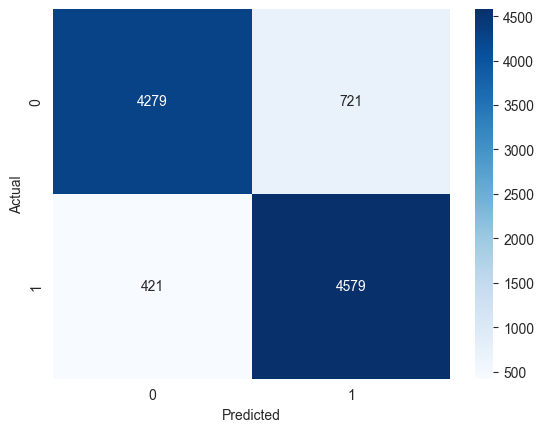

In [18]:
print(classification_report(y_test_num, y_pred))
cm = confusion_matrix(y_test_num, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
model.save(models_path + "artifacts/dl_baseline_model.keras")
joblib.dump(tokenizer, models_path + "artifacts/tokenizer.pkl")

['../models/artifacts/tokenizer.pkl']

## Day 6 – Baseline Deep Learning

- Old ML Logistic Regression model is better than Baseline Deep learning model
- DL Model has slightly overfitting
- The train time is quite fast
